# Multi Variate Analysis 
This jupyter python notebook conducts multi variate analysis relevant to the research question. The research questions is as follows: <br>
<br>
How different variables such as **actual delivery time**, **the difference between actual and estimated wait time**, **order status**, **freight value**, **payment value**, **payment installment** affect the **review score** in each of the different **product type categories**, `Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`? <br>

However, in this python notebook, random forest is used to help better the machine learning. Decision tree is not the best solution as seen in part 5. A decision tree is a single classification tree. A random forest on the other hand is a "forest", a multitude of classification trees. The random forest algorithm then decides which is the best tree with the lowest error rates. 
https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
olist_products_dataset = pd.read_csv("olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("product_category_name_translation.csv")

### Merging the Datasets

In [3]:
olist_merge = olist_orders_dataset.merge(olist_order_reviews_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_payments_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_items_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_products_dataset, on="product_id", how = 'left')

### Removing Duplicates and extracting needed variables 

In [4]:
olist_merge.drop_duplicates(subset=["review_score", "order_id"], inplace = True)

In [5]:
dataAnalysis = pd.DataFrame(olist_merge[['order_status','order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score', 'payment_installments', 'payment_value', 'freight_value', 'product_category_name']])

In [6]:
# Creating a list of the time related variables 
time = ["order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date", "order_approved_at"]
# Changing the time related variables to datetime format using the list 
for column in time:
    dataAnalysis.loc[:, column] = pd.to_datetime(dataAnalysis[column])

In [7]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"actual_wait_time"] = (dataAnalysis['order_delivered_customer_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [8]:
# Calculating the estimated wait time 
dataAnalysis.loc[:,"estimated_wait_time"] = (dataAnalysis['order_estimated_delivery_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [9]:
#Actual minus estimated wait time 
dataAnalysis.loc[:,"actualxestimated"] = (dataAnalysis['actual_wait_time']-dataAnalysis['estimated_wait_time'])

In [10]:
dataAnalysis.drop(columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'estimated_wait_time'], inplace = True)

### Further analysis of predictors
Categorical types: Order Status
<br>
Numerical types: payment installments, payment value, freight value, actual wait time, actualxestimated 

So when using multi variate, it is important to know which is categorical and which is numerical. 

The numerical types are dependent on the order status being delivered. Hence, it needs to be filtered. 

In [11]:
dataAnalysis = dataAnalysis.loc[(dataAnalysis["order_status"]=="delivered")]

In [12]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"reviewscore"] = dataAnalysis["review_score"]//3

The data is still imbalanced. However, it will be further balanced after being split into the different top ten product categories. 

In [13]:
# Original review score no longer needed
dataAnalysis.drop(columns = ['review_score'], inplace = True)

#### Next, narrowing down to the top ten products
`Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`

In [14]:
#merging with english name first 
dataAnalysis = pd.merge(dataAnalysis,product_category_name_translation,how="left",on="product_category_name")

In [15]:
housewareProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="housewares")]

# Defining a balance function to balance the two classes
def balancing(dataframe):
    # Class count
    count_class_1, count_class_0 = dataframe.reviewscore.value_counts() #split the dataframe based on review scores into 1 and 0

    # Divide by class 1 and 0 to create two different dataframes
    df_class_0 = dataframe[dataframe['reviewscore'] == 0] 
    df_class_1 = dataframe[dataframe['reviewscore'] == 1]

    #Sample the class 0 (review score 0) by the number of review 1s
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    dataframe = pd.concat([df_class_1, df_class_0_over], axis=0)
    return dataframe #return the dataframe

housewareProd = balancing(housewareProd)
housewareProd.info()
# since there is no null values, no further cleaning is required. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10024 entries, 0 to 52451
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   10024 non-null  object 
 1   payment_installments           10024 non-null  float64
 2   payment_value                  10024 non-null  float64
 3   freight_value                  10024 non-null  float64
 4   product_category_name          10024 non-null  object 
 5   actual_wait_time               10024 non-null  float64
 6   actualxestimated               10024 non-null  float64
 7   reviewscore                    10024 non-null  int64  
 8   product_category_name_english  10024 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 783.1+ KB


In [16]:
autoProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="auto")]
autoProd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3797 entries, 2 to 96645
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   3797 non-null   object 
 1   payment_installments           3797 non-null   float64
 2   payment_value                  3797 non-null   float64
 3   freight_value                  3797 non-null   float64
 4   product_category_name          3797 non-null   object 
 5   actual_wait_time               3796 non-null   float64
 6   actualxestimated               3796 non-null   float64
 7   reviewscore                    3797 non-null   int64  
 8   product_category_name_english  3797 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 296.6+ KB


In [17]:
#Needs cleaning and removal of null values 
autoProd = autoProd.loc[(autoProd["actual_wait_time"].notnull())]
autoProd=balancing(autoProd)

In [18]:
#No need further cleaning
furnitureProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="furniture_decor")]
furnitureProd = balancing(furnitureProd)

In [19]:
CompAcProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="computers_accessories")]

In [20]:
#Needs cleaning and removal of null values 
CompAcProd = CompAcProd.loc[(CompAcProd["actual_wait_time"].notnull())]
CompAcProd=balancing(CompAcProd)

In [21]:
healthProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="health_beauty")]

In [22]:
#Needs further cleaning 
healthProd = healthProd.loc[(healthProd["payment_installments"].notnull())]
healthProd=balancing(healthProd)

In [23]:
sportsProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="sports_leisure")]

In [24]:
#Needs further cleaning 
sportsProd = sportsProd.loc[(sportsProd["actual_wait_time"].notnull())]
sportsProd=balancing(sportsProd)

#### Desicion tree on the product types 
`Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`

In [25]:
def train_and_predict(dataframe, estim, mdepth):
    # Import essential models and functions from sklearn
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix

    # Extract Response and Predictors
    y = pd.DataFrame(dataframe['reviewscore'])
    X = pd.DataFrame(dataframe[["payment_installments", "payment_value", "freight_value", "actual_wait_time", "actualxestimated"]]) 

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    # Import RandomForestClassifier model from Scikit-Learn
    from sklearn.ensemble import RandomForestClassifier

    # Create the Random Forest object
    rforest = RandomForestClassifier(n_estimators = estim,  # n_estimators denote number of trees
                                     max_depth = mdepth)       # set the maximum depth of each tree

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train.reviewscore.ravel())

    # Predict the Response corresponding to Predictors
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model: Train Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    TN = confusion_matrix_train[0,0]
    TP = confusion_matrix_train[1,1]
    FP = confusion_matrix_train[0,1]
    FN = confusion_matrix_train[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ", FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model: Test Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    TN = confusion_matrix_test[0,0]
    TP = confusion_matrix_test[1,1]
    FP = confusion_matrix_test[0,1]
    FN = confusion_matrix_test[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ",FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.996082370668006
True Negative Rate      :  1.0
True Positive Rate      :  0.9921702469383658
False Negative Rate     :  0.00782975306163421
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.996082370668006
True Negative Rate      :  0.994588093806374
True Positive Rate      :  0.9245169082125604
False Negative Rate     :  0.07548309178743962
False Positive Rate     :  0.005411906193625977


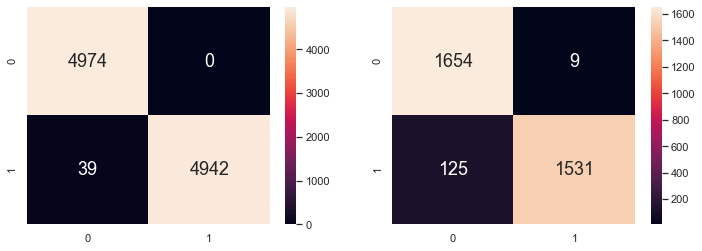

In [26]:
train_and_predict(sportsProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9957435488161746
True Negative Rate      :  0.9997333333333334
True Positive Rate      :  0.9917728237791932
False Negative Rate     :  0.008227176220806794
False Positive Rate     :  0.0002666666666666667

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9957435488161746
True Negative Rate      :  0.9960380348652932
True Positive Rate      :  0.9003215434083601
False Negative Rate     :  0.09967845659163987
False Positive Rate     :  0.003961965134706815


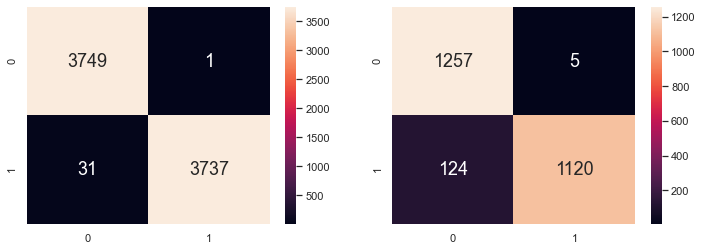

In [27]:
train_and_predict(housewareProd, 10, 400)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9960643694245234
True Negative Rate      :  1.0
True Positive Rate      :  0.9921287388490467
False Negative Rate     :  0.007871261150953298
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9960643694245234
True Negative Rate      :  0.9979013641133263
True Positive Rate      :  0.9338929695697796
False Negative Rate     :  0.06610703043022036
False Positive Rate     :  0.002098635886673662


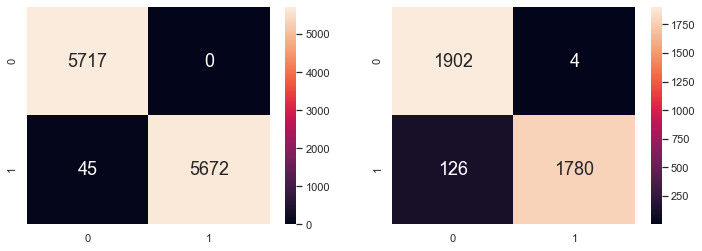

In [28]:
train_and_predict(healthProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.99474216380182
True Negative Rate      :  0.9995898277276456
True Positive Rate      :  0.9900279218189071
False Negative Rate     :  0.00997207818109294
False Positive Rate     :  0.00041017227235438887

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.99474216380182
True Negative Rate      :  0.9953434225844005
True Positive Rate      :  0.8974683544303798
False Negative Rate     :  0.10253164556962026
False Positive Rate     :  0.004656577415599534


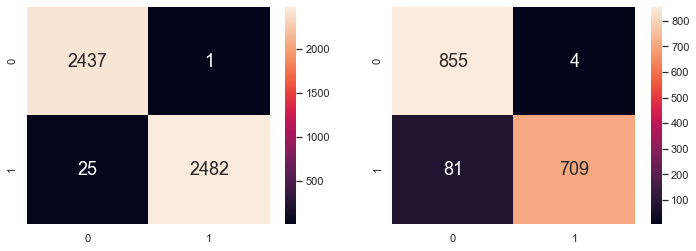

In [29]:
train_and_predict(autoProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9948428879827297
True Negative Rate      :  0.9990421455938697
True Positive Rate      :  0.9906295050456512
False Negative Rate     :  0.00937049495434887
False Positive Rate     :  0.0009578544061302681

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9948428879827297
True Negative Rate      :  0.9913232104121475
True Positive Rate      :  0.8904795991410165
False Negative Rate     :  0.10952040085898354
False Positive Rate     :  0.008676789587852495


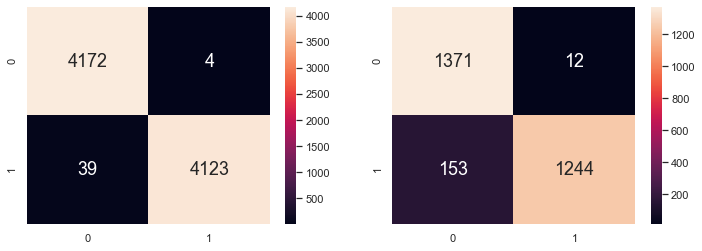

In [30]:
train_and_predict(CompAcProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9981041456016178
True Negative Rate      :  1.0
True Positive Rate      :  0.9962649402390438
False Negative Rate     :  0.0037350597609561755
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9981041456016178
True Negative Rate      :  0.9804205946337926
True Positive Rate      :  0.9229547259729944
False Negative Rate     :  0.07704527402700556
False Positive Rate     :  0.019579405366207395


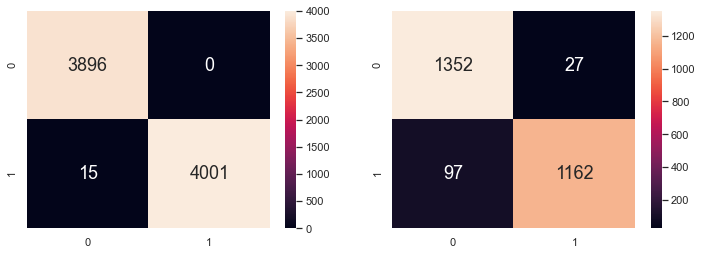

In [31]:
train_and_predict(furnitureProd, 100, 200)

# Check Point: Analysis 


There is a significant improvement in the performance of the machine learning model when using random forest as opposed to using decision tree. The classification accuracy increases to almost 80% for most product types. Additionally, the false positive rates drop below 30%. However, more can be done to find the hyperparameters which results in the most accurate random forest model being made. 

**Hyperparameters** 
Hyperparamters in this case is the `n_estimators` and the `max_depth` which is the number of decision trees in the forest and the maximum depth each tree respectively. Grid Search is used to find the best hyperparameters. 